In [33]:
# Update PATH environment variable
import os
os.environ['PATH'] = '/opt/homebrew/bin:' + os.environ['PATH']

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_dt, get_rz, get_rz_full

from scipy.stats import skew, kurtosis

### This code plots the lowest order moments from GPI data for shot 1110201016 (EDA H-mode), 1110201011 (ELM-free H-mode) and 1160616018 (phmic) 

In [34]:
shotlist = [1110201016, 1110201011, 1160616018]
f_GWs = [greenwald_fraction[shot] for shot in shotlist]
marker_list = ['^', 'o', 'v']
color_list = ['#785EF0', '#DC267F', '#FFB000']
label_name = ['EDA H', 'ELM-free H', 'Ohmic']

In [35]:
shot_statistics = {}

for shot in shotlist:
    t_start = shot_time_window[shot][0]
    t_end = shot_time_window[shot][1]
    f_GW = greenwald_fraction[shot]
    path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
    ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')
    R_coordinates, Z_coordinates = get_rz_full(ds)

    # Remove dead pixels
    path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
    dead_pix = np.load(
        str(path_dead_pixel)
        + "/"
        + f"dead_pixels_shot_{shot}.npz"
    )
    dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
    dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
    for y in range(dead_pix_arr_ds.shape[0]):
        for x in range(dead_pix_arr_ds.shape[1]):
            if dead_pix_arr_ds[9-y, x]:
                ds['frames'].loc[dict(y=y, x=x)] = np.nan

    ds = ds.sel(time=slice(t_start, t_end))

    rows = 10
    columns = 9

    # Rows are y, columns are x
    two_dim_mean = np.zeros((rows, columns))
    two_dim_std = np.zeros((rows, columns))
    two_dim_skew = np.zeros((rows, columns))
    two_dim_flat = np.zeros((rows, columns))
    two_dim_gamma = np.zeros((rows, columns))

    for row in range(rows):
        for col in range(columns):
            data = get_signal(x=col, y=row, ds=ds)
            time = get_time(x=col, y=row, ds=ds)
            frames_mean = data.mean()
            frames_std = data.std()

            two_dim_mean[row, col] = frames_mean
            two_dim_std[row, col] = frames_std
            two_dim_data = (data - frames_mean) / frames_std
            two_dim_skew[row, col] = skew(data)
            two_dim_flat[row, col] = kurtosis(data)
            two_dim_gamma[row, col] = (frames_mean/frames_std)**2

    # Store statistics for this shot in the shot_statistics dictionary
    shot_statistics[shot] = {
        'two_dim_mean': two_dim_mean,
        'two_dim_std': two_dim_std,
        'two_dim_skew': two_dim_skew,
        'two_dim_flat': two_dim_flat,
        'two_dim_gamma': two_dim_gamma
    }

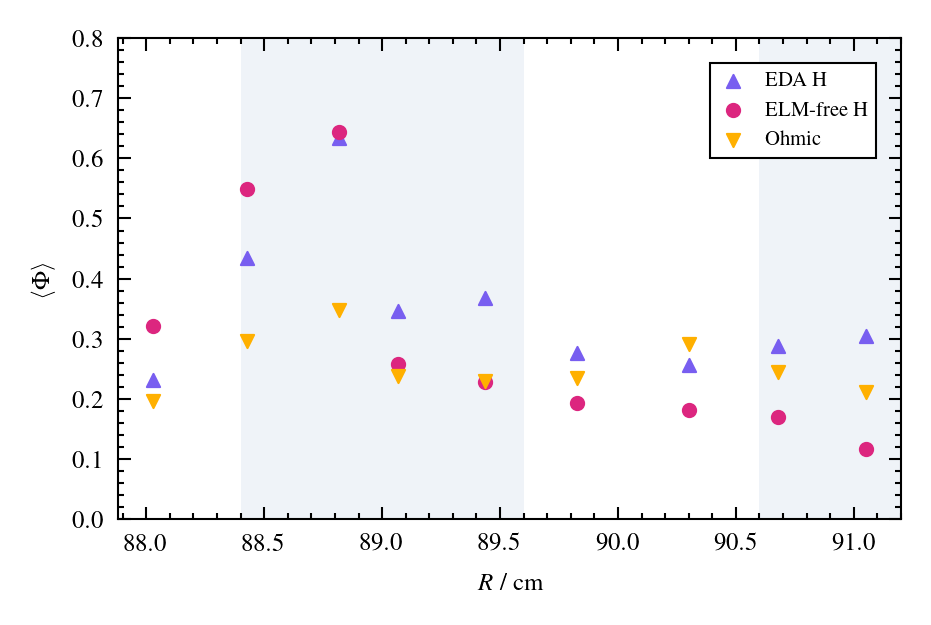

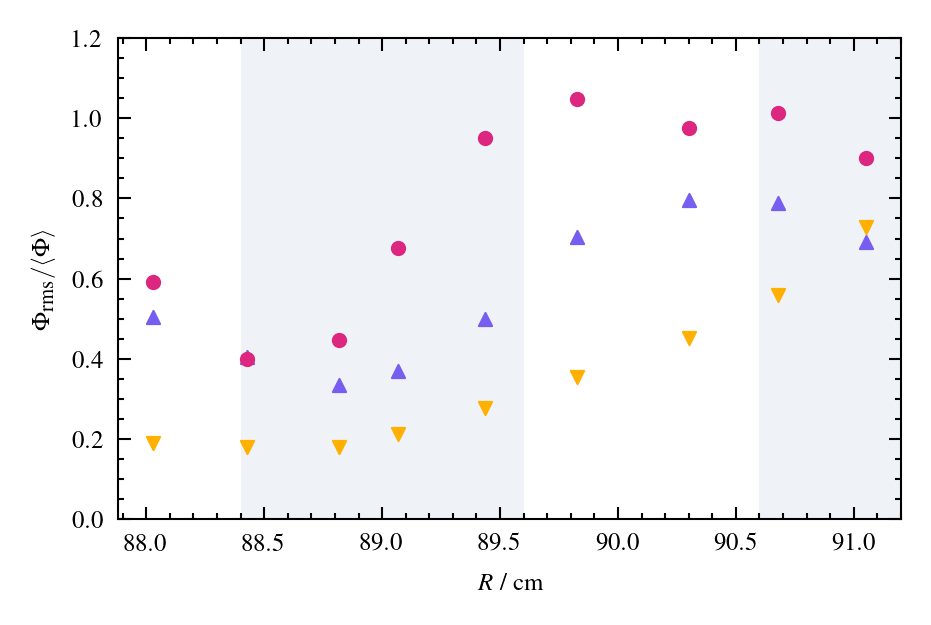

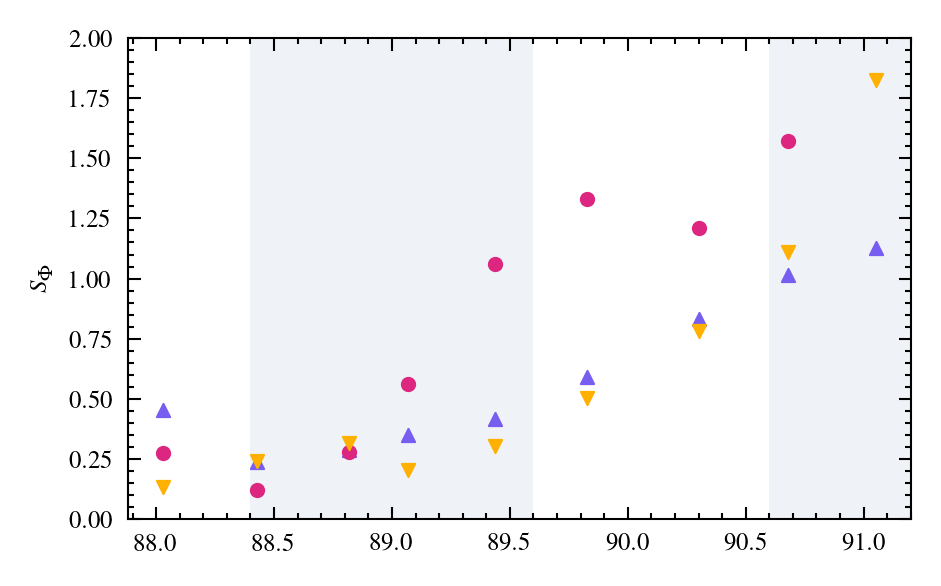

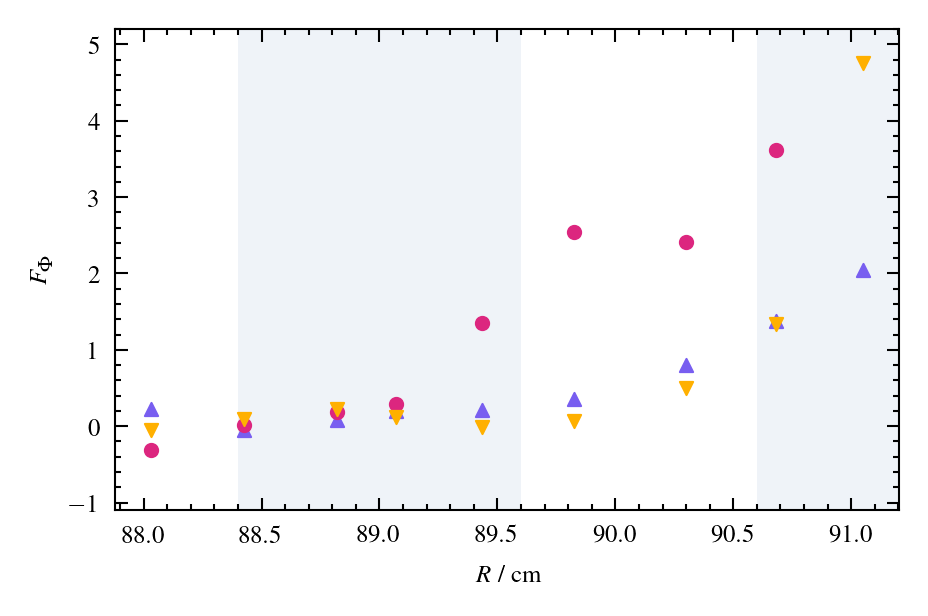

In [17]:
save = False

axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["font.size"] = 6
plt.rcParams["legend.fontsize"] = 5
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.minor.size"] = 1.5
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.minor.size"] = 1.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5

#---------------- Time averaged mean --------------#
fig, ax = plt.subplots()
for idx, shot in enumerate(shotlist):
    ax.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_mean'], axis=0), color=color_list[idx], marker=marker_list[idx], label=label_name[idx], s=10)
ax.set_xlim([min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15])
ax.set_ylim([0, 0.8])
ax.set_ylabel(r"$ \langle \Phi \rangle$")
ax.set_xlabel(r"$R$ / cm")
ax.legend(loc='upper right', borderaxespad=1.2)

# Shaded area for LCFS and limiter
ax.axvspan(88.4, 89.6, facecolor="lightsteelblue", alpha=0.2, zorder=0)
ax.axvspan(90.6, 91.5, facecolor="lightsteelblue", alpha=0.2, zorder=0)

#---------------- Relative fluctuation level --------------#
fig2, ax = plt.subplots()
for idx, shot in enumerate(shotlist):
    ax.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_std'], axis=0) / np.nanmean(shot_statistics[shot]['two_dim_mean'], axis=0), color=color_list[idx], marker=marker_list[idx], s=10)
ax.set_xlim([min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15])
ax.set_ylabel(r"$\Phi_{\mathrm{rms}} /  \langle \Phi \rangle$") # \hspace{0.1em}
ax.set_xlabel(r"$R$ / cm")
#ax.legend(loc='upper left')
ax.set_ylim(bottom=0, top=1.2)

# Shaded area for LCFS and limiter
ax.axvspan(88.4, 89.6, facecolor="lightsteelblue", alpha=0.2, zorder=0)
ax.axvspan(90.6, 91.5, facecolor="lightsteelblue", alpha=0.2, zorder=0)

#---------------- Skewness --------------#
fig3, ax = plt.subplots()
for idx, shot in enumerate(shotlist):
    ax.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_skew'], axis=0), color=color_list[idx], marker=marker_list[idx], s=10)
ax.set_xlim([min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15])
ax.set_ylabel(r"$S_{\Phi}$")
ax.set_ylim(top=2, bottom=0)
#ax.set_ylabel(r"$S_{\Phi}$")
#ax.set_xlabel(r"$R$ / cm")
#ax.legend(loc='upper left')

# Shaded area for LCFS and limiter
ax.axvspan(88.4, 89.6, facecolor="lightsteelblue", alpha=0.2, zorder=0)
ax.axvspan(90.6, 91.5, facecolor="lightsteelblue", alpha=0.2, zorder=0)

#---------------- Flatness --------------#
fig4, ax = plt.subplots()
for idx, shot in enumerate(shotlist):
    ax.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_flat'], axis=0), color=color_list[idx], marker=marker_list[idx], s=10)
ax.set_xlim([min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15])
ax.set_ylabel(r"$F_{\Phi}$")
ax.set_xlabel(r"$R$ / cm")
ax.set_ylim(top=5.2, bottom=-1.1)
#ax.legend(loc='upper left')

# Shaded area for LCFS and limiter
ax.axvspan(88.4, 89.6, facecolor="lightsteelblue", alpha=0.2, zorder=0)
ax.axvspan(90.6, 91.5, facecolor="lightsteelblue", alpha=0.2, zorder=0)


plt.plot()
if save:
    format = "pdf"
    foldername = "/Users/ahe104/Box/time_delay_estimation/velocity_field/PSI/"

    filename = f"apd_mulitple_profile_average_f_GW_mean.{format}"
    filename2 = f"apd_mulitple_profile_average_f_GW_rel_fluct.{format}"
    filename3 = f"apd_mulitple_profile_average_f_GW_skew.{format}"
    filename4 = f"apd_mulitple_profile_average_f_GW_flat.{format}"

    fig.savefig(foldername + filename, bbox_inches="tight", format=format)
    fig2.savefig(foldername + filename2, bbox_inches="tight", format=format)
    fig3.savefig(foldername + filename3, bbox_inches="tight", format=format)
    fig4.savefig(foldername + filename4, bbox_inches="tight", format=format)


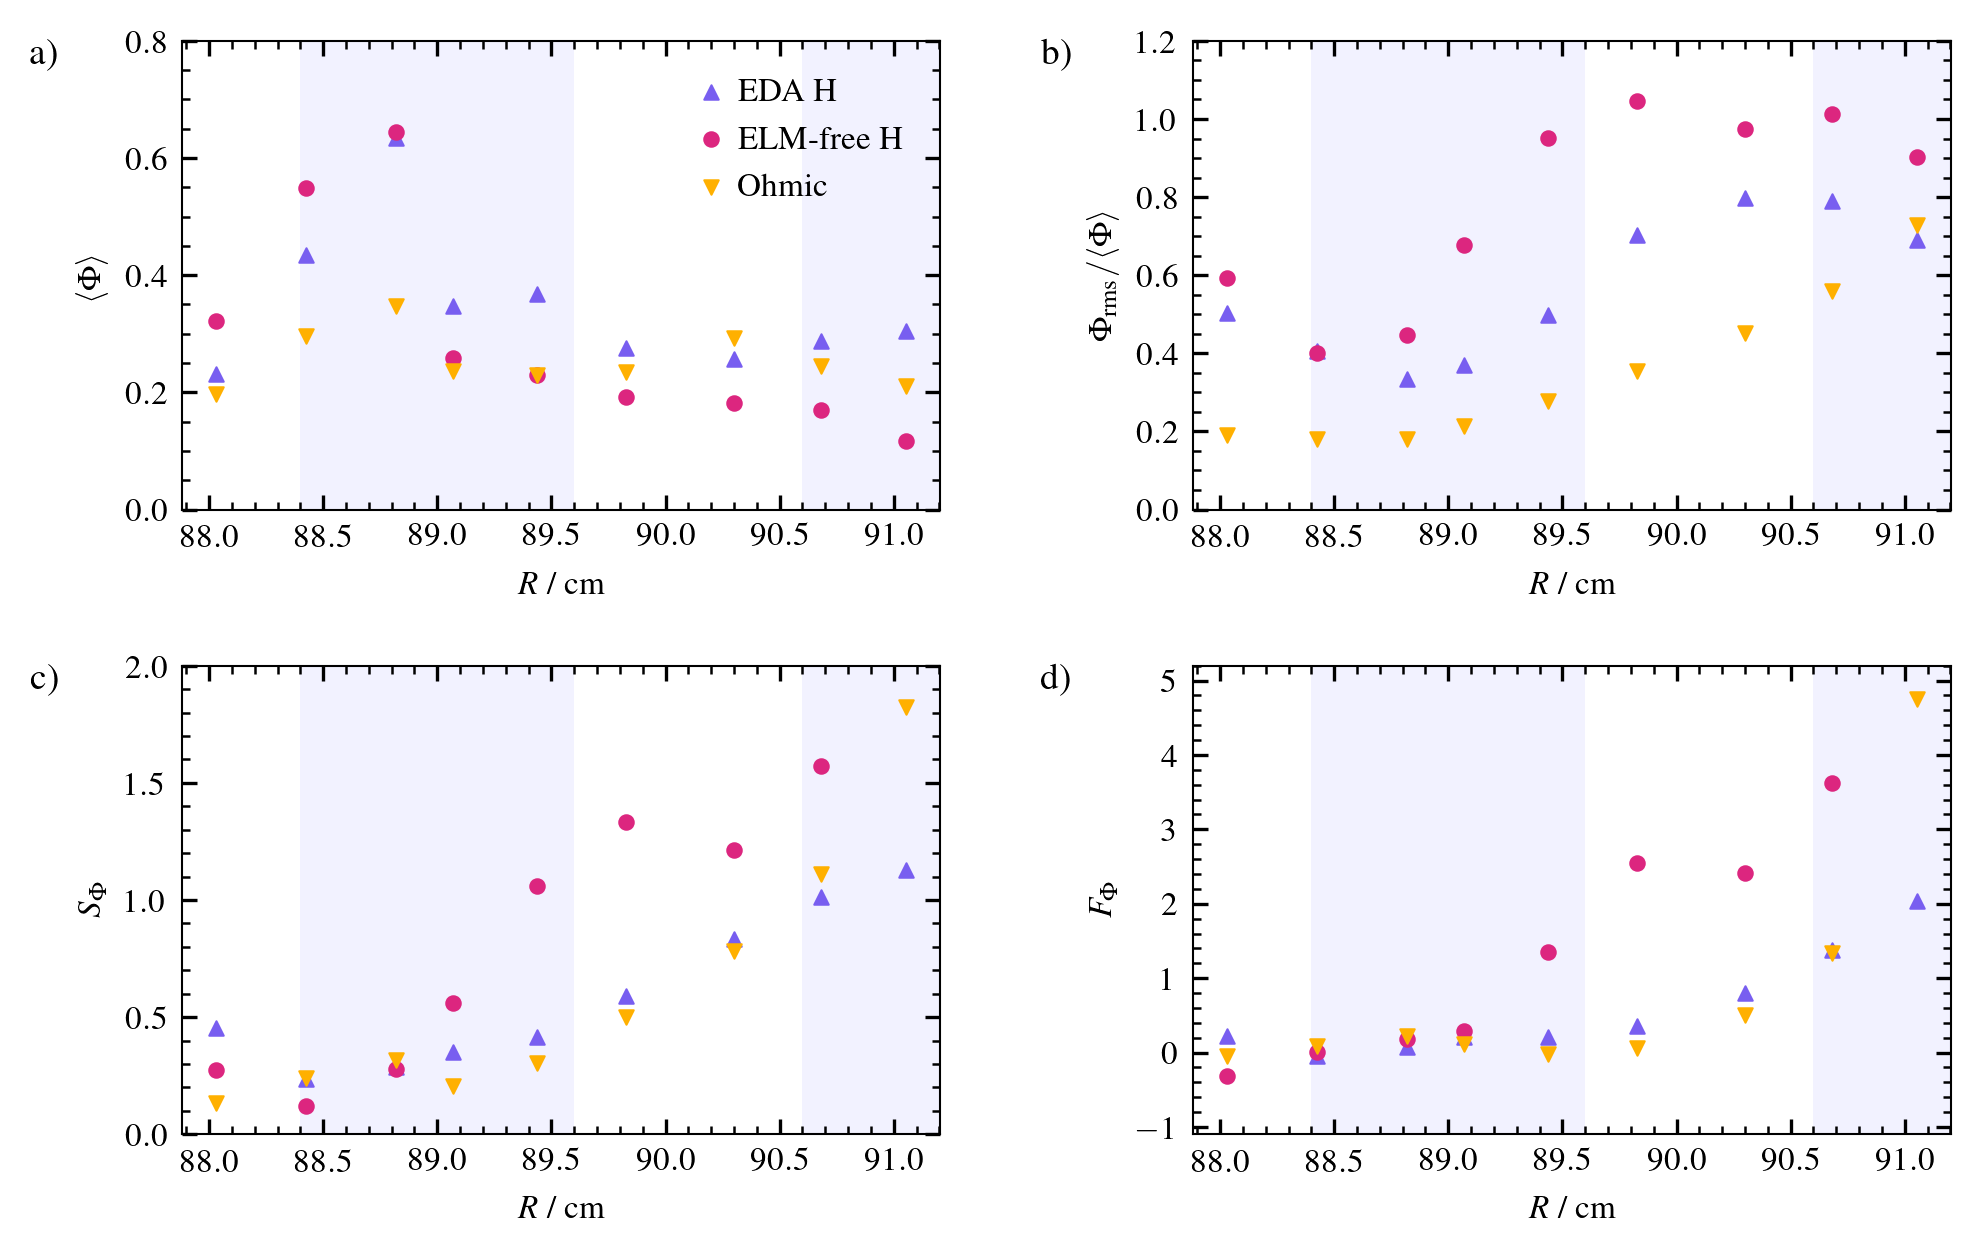

In [20]:
# Kode fra Olga! Modifisert av meg

save = True

params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')


def fixed_aspect_ratio(ratio, axes):
    '''
    Set a fixed aspect ratio on matplotlib plots
    regardless of axis units
    '''
    for ax in axes:
      xvals,yvals = ax.get_xlim(),ax.get_ylim()
      xrange = xvals[1]-xvals[0] if ax.get_xscale() == "linear" else np.log10(xvals[1])-np.log10(xvals[0])
      yrange = yvals[1]-yvals[0] if ax.get_yscale() == "linear" else np.log10(yvals[1])-np.log10(yvals[0])
      ax.set_aspect(ratio*(xrange/yrange))

rows = 2
columns = 2

fig, ax = cosmoplots.figure_multiple_rows_columns(rows, columns, labels=['a)','b)','c)','d)'],fontsize=9)

ax0=ax[0]
ax1=ax[1]
ax2=ax[2]
ax3=ax[3]

ylabel_mean = r"$ \langle \Phi \rangle$"
ylabel_rel_fluct = r"$\Phi_{\mathrm{rms}} /  \langle \Phi \rangle$"
ylabel_skew = r"$S_{\Phi}$"
ylabel_flat = r"$F_{\Phi}$"
xlabel = r"$R$ / cm"
xlim = [min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15]

marker_size = 9


for idx, shot in enumerate(shotlist):
    ax0.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_mean'], axis=0), color=color_list[idx], marker=marker_list[idx], label=label_name[idx], s=12)
    ax1.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_std'], axis=0) / np.nanmean(shot_statistics[shot]['two_dim_mean'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12)
    ax2.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_skew'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12)
    ax3.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_flat'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12)

ax0.set_ylim([0, 0.8])
ax0.set_xlim(xlim)
ax0.set_ylabel(ylabel_mean, rotation=90, labelpad=4)
ax0.set_xlabel(xlabel)
ax0.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax0.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)
ax0.legend(frameon=False, labelspacing=0.5, borderaxespad=0.7, handletextpad=0.1)

ax1.set_ylim(bottom=0, top=1.2)
ax1.set_xlim(xlim)
ax1.set_ylabel(ylabel_rel_fluct, rotation=90, labelpad=4)
ax1.set_xlabel(xlabel)
ax1.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax1.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)

ax2.set_ylim(top=2, bottom=0)
ax2.set_xlim(xlim)
ax2.set_ylabel(ylabel_skew, rotation=90, labelpad=4)
ax2.set_xlabel(xlabel)
ax2.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax2.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)

ax3.set_ylim(top=5.2, bottom=-1.1)
ax3.set_xlim(xlim)
ax3.set_ylabel(ylabel_flat, rotation=90, labelpad=4)
ax3.set_xlabel(xlabel)
ax3.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax3.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)



fixed_aspect_ratio(1 / (0.5 * (1. + np.sqrt(5.0))), [ax0, ax1, ax2, ax3])

if save == True:
  formats = ["pdf", "eps"]
  foldername = "/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/"
  for fmt in formats:
    filename = f"GPI_profiles_lowest_order_moments.{fmt}"
    fig.savefig(foldername + filename, format=fmt)

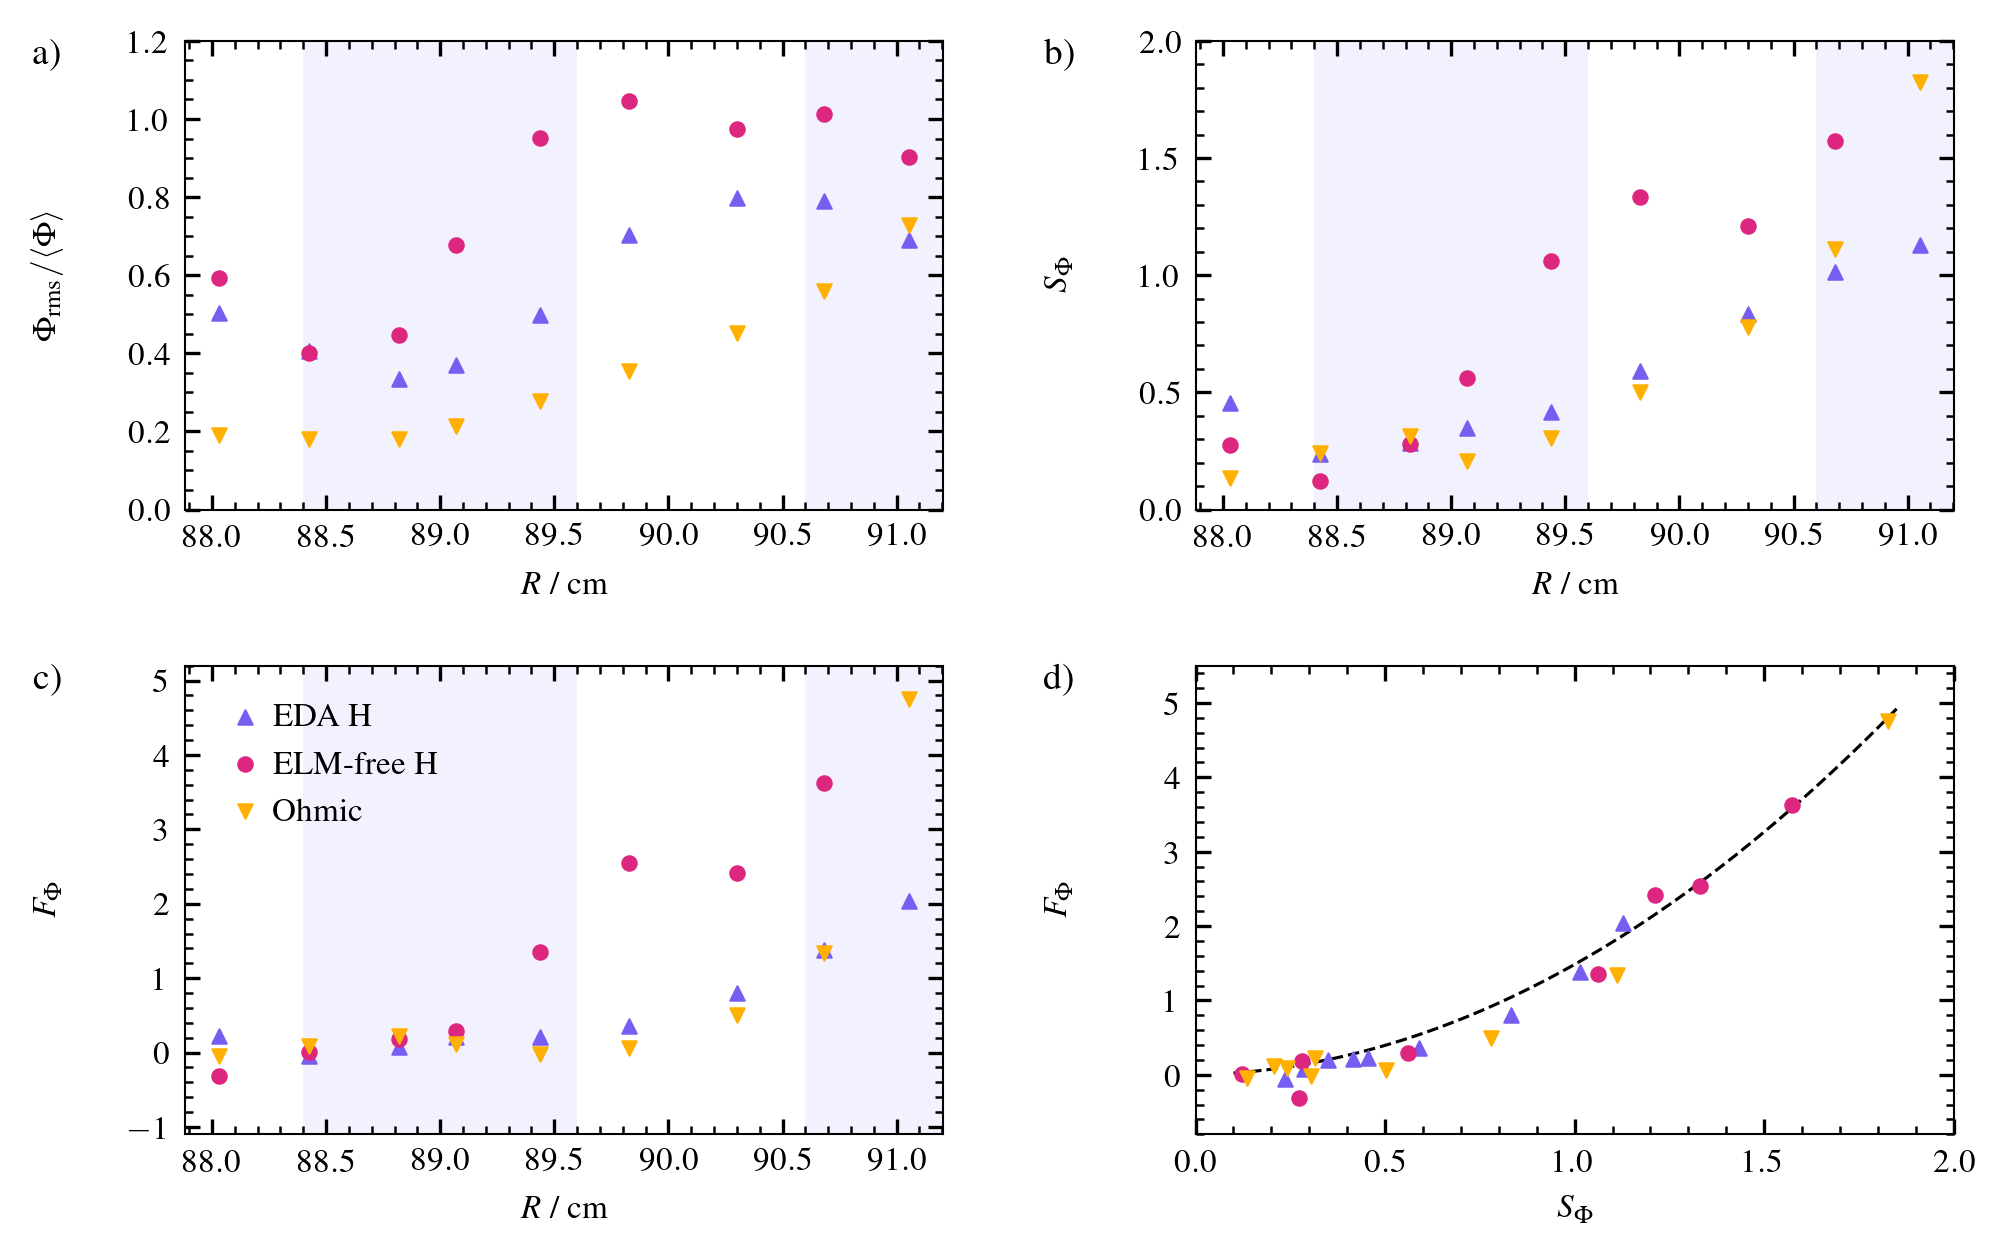

In [36]:
# Kode fra Olga! Modifisert av meg

save = True

params = {}
cosmoplots.set_rcparams_dynamo(params, num_cols=1)
plt.style.use(["cosmoplots.default"])
plt.rcParams['text.latex.preamble'] =  r'\usepackage{amsmath}' r'\usepackage{times}' r'\usepackage{mathptmx}' r'\usepackage{amssymb}' r'\newcommand{\taup}{\ensuremath{\tau_\shortparallel}}' r'\newcommand{\wh}{\widehat}' r'\newcommand{\ave}[1]{{\left<#1\right>}}'
plt.rc('font',family='Times New Roman')


def fixed_aspect_ratio(ratio, axes):
    '''
    Set a fixed aspect ratio on matplotlib plots
    regardless of axis units
    '''
    for ax in axes:
      xvals,yvals = ax.get_xlim(),ax.get_ylim()
      xrange = xvals[1]-xvals[0] if ax.get_xscale() == "linear" else np.log10(xvals[1])-np.log10(xvals[0])
      yrange = yvals[1]-yvals[0] if ax.get_yscale() == "linear" else np.log10(yvals[1])-np.log10(yvals[0])
      ax.set_aspect(ratio*(xrange/yrange))

rows = 2
columns = 2

fig, ax = cosmoplots.figure_multiple_rows_columns(rows, columns, labels=['a)','b)','c)','d)'],fontsize=9)

ax0=ax[0]
ax1=ax[1]
ax2=ax[2]
ax3=ax[3]

ylabel_mean = r"$ \langle \Phi \rangle$"
ylabel_rel_fluct = r"$\Phi_{\mathrm{rms}} /  \langle \Phi \rangle$"
ylabel_skew = r"$S_{\Phi}$"
ylabel_flat = r"$F_{\Phi}$"
xlabel = r"$R$ / cm"
xlim = [min(R_coordinates[:, 0]) - 0.15, max(R_coordinates[:, 0]) + 0.15]

marker_size = 9



for idx, shot in enumerate(shotlist):
    #ax0.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_mean'], axis=0), color=color_list[idx], marker=marker_list[idx], label=label_name[idx], s=12)
    ax0.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_std'], axis=0) / np.nanmean(shot_statistics[shot]['two_dim_mean'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12)
    ax1.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_skew'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12)
    ax2.scatter(R_coordinates[:,0], np.nanmean(shot_statistics[shot]['two_dim_flat'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12, label=label_name[idx])
    ax3.scatter(np.nanmean(shot_statistics[shot]['two_dim_skew'], axis=0), np.nanmean(shot_statistics[shot]['two_dim_flat'], axis=0), color=color_list[idx], marker=marker_list[idx], s=12)

# ax0.set_ylim([0, 0.8])
# ax0.set_xlim(xlim)
# ax0.set_ylabel(ylabel_mean, rotation=90, labelpad=4)
# ax0.set_xlabel(xlabel)
# ax0.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
# ax0.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)
# ax0.legend(frameon=False, labelspacing=0.5, borderaxespad=0.7, handletextpad=0.1)

ax0.set_ylim(bottom=0, top=1.2)
ax0.set_xlim(xlim)
ax0.set_ylabel(ylabel_rel_fluct, rotation=90, labelpad=4)
ax0.set_xlabel(xlabel)
ax0.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax0.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)

ax1.set_ylim(top=2, bottom=0)
ax1.set_xlim(xlim)
ax1.set_ylabel(ylabel_skew, rotation=90, labelpad=4)
ax1.set_xlabel(xlabel)
ax1.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax1.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)

ax2.set_ylim(top=5.2, bottom=-1.1)
ax2.set_xlim(xlim)
ax2.set_ylabel(ylabel_flat, rotation=90, labelpad=4)
ax2.set_xlabel(xlabel)
ax2.axvspan(88.4, 89.6, facecolor=(0.95, 0.95, 1.0), zorder=0) # I asked chatGPT what is a lighter lavendel color: (0.95, 0.95, 1.0)
ax2.axvspan(90.6, 91.5, facecolor=(0.95, 0.95, 1.0), zorder=0)
ax2.legend(frameon=False, labelspacing=0.5, borderaxespad=0.7, handletextpad=0.1)

def parabolic_fit(x):
    # Since we want the parabola to pass through (0, 0) and (2.8, 15),
    # we can set c = 0 and solve for a and b using these points.
    # Assume a simple form y = ax^2 + bx
    # At x = 0, y = 0 => c = 0
    # At x = 2.8, y = 15 => 15 = a*(2.8)^2 + b*2.8
    # We can choose a = 15 / (2.8)^2 for simplicity and b = 0 for a pure quadratic
    # a = 15 / (2.8)**2
    a = 5 / (1.9)**2
    b = 0.1
    return a * x**2 + b * x
# Generate x values for the parabola
x_values = np.linspace(0.1, 1.85, 100)
y_values = parabolic_fit(x_values)

ax3.plot(x_values, y_values, color='black', linestyle='--', label='Parabolic Fit', zorder=0)


ax3.set_xlim([0, 2])
ax3.set_ylim([-0.8, 5.5])
ax3.set_xlabel(ylabel_skew, labelpad=4)
ax3.set_ylabel(ylabel_flat, labelpad=4)

fixed_aspect_ratio(1 / (0.5 * (1. + np.sqrt(5.0))), [ax0, ax1, ax2, ax3])

if save == True:
  formats = ["pdf", "eps"]
  foldername = "/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/"
  for fmt in formats:
    filename = f"GPI_profiles_lowest_order_moments_skew_vs_flat.{fmt}"
    fig.savefig(foldername + filename, format=fmt)